# Extracting fish nest from images

In [1]:
import numpy as np
from matplotlib import pyplot, transforms
from image_extract import get_obstacle
import matplotlib.animation as animation
from PIL import Image
import os

In [2]:
# choice = "pipe"
#choice = "nest"
choice = "pipe&nest"

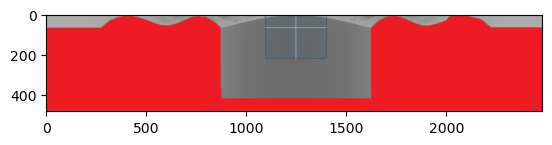

In [3]:
if choice == "pipe&nest": 
    im = Image.open(os.path.join("images", "avec_nid.png"))
elif choice == "pipe":
    im = Image.open(os.path.join("images", "sans_nid.png"))
width = im.width
height = im.height
(left, up, right, bottom) = (0, 380, width, height)

im = im.crop((left, up, right, bottom))
pyplot.imshow(im)

### Resizing image

(78, 400)


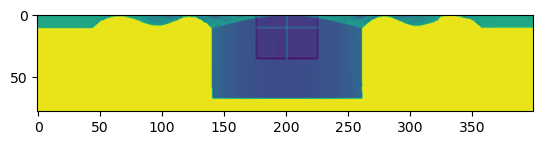

In [4]:
# resizing image
new_width = 400
width_percent = (new_width / float(im.size[0]))
new_height = int((float(im.size[1]) * float(width_percent)))

resized_img = im.resize((new_width, new_height))
# resized_img = resized_img.convert("L")

np_img = np.array(resized_img)
np_img = np_img[:, :, 0]
print(np_img.shape)
pyplot.imshow(np_img)

### Extracting red band from image

In [5]:
#np_img[75, :]

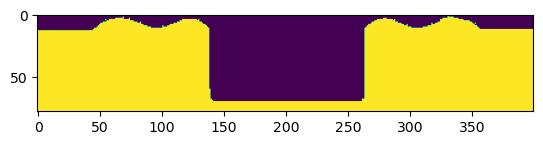

In [6]:
pipe_with_nest = np.full(np_img.shape, False)
for x in range(np_img.shape[0]): 
    for y in range(np_img.shape[1]): 
        if np_img[x][y] == 237:
            pipe_with_nest[x][y] = True

pyplot.imshow(pipe_with_nest)

# Simulating fish nest with Lattice Boltzmann D2Q9
Inspiration for this simulation [here](https://www.youtube.com/watch?v=JFWqCQHg-Hs&t=683s).

The code is divided into a streaming and ... component. 

Works by splitting domain into a lattice, each one has nine potential velocites. 
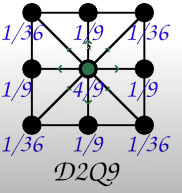
In the image above, the velocity going upwards transvers it's velocity upwards. Each direction has a probability of happening. For example 1/9 chance of going directly up, down, right or left. 
Each potential velocity is called a node, the probability is the __discrete velocity: ex(1,0)__.


In [7]:
def distance(x1, y1, x2, y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

In [8]:
plot_every = 100 # 
frames = []
curl = []

## Defining constants

|Constant|Explanation|
|---|---|
|Nx|Size of the lattice in x|
|Ny|Size of the lattice in y|
|tau| Kinematic viscosity / timescale|
|Nt|Ammount of iterations through times|
|cxy|9 possible discrete velocities in x (vector is [x, y]|
|cyx|Same as above but in y, the x dimension is in the corresponding index in cyx|
|weights|Probabilities the cell to take on a specific velocity, commes from connection of this method with the navier-Stokes equations, their sum is 1|


In [9]:
# define variables
Nx = 400 # width of the simulation
Ny = 150 # height of the simulation
tau = .53 # kinematic viscosity
Nt = 8000 # iterations through time

# lattice speeds ands weights
# defining discrete velocity
NL = 9
# the length of all these lists should be 9
cxs = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1]) # checked
cys = np.array([0, 1, 1, 0, -1, -1,-1, 0, 1]) # checked
# define wiegths = values assigned to each of the note, linked to Navier-Stokes
weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36]) # checked

# Initial conditions
## Adding slight inconsistencies (mesoscopic velocity)
F = np.ones((Ny, Nx, NL)) + .001 * np.random.randn(Ny, Nx, NL)
#                            ^
#                            |
#                   Random inconstencies


# At each cell in each ones of it's third node's add a value of 2.5
F[:, :, 3] = 2.5 # checked
F.shape

(100, 400, 9)

## Defining obstacle areas
- Define a table cylinder of same dimension as our simulation containing either true of false:
- True = Obstacle cell
- False = Empty cell, the fluid can circulate here

Nest is of dimension -> (23, 300) -> the structure rests on the higher values
Cylinder is of shape -> (30, 400)

(100, 400)
(78, 400)


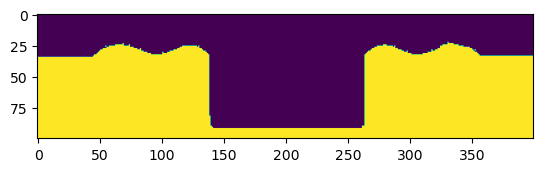

In [10]:
# creating obstacle
# start by making an new array with the same dimimentions as our simulation
cylinder = np.full((Ny, Nx), False) # if the value is false = empty space, else it's an obstacle
if choice == "pipe":
    nest = pipe_with_nest
elif choice == "nest":
    nest = get_obstacle() # return as np array containing either true of false
elif choice == "pipe&nest":
    nest = pipe_with_nest


vertical_offset = cylinder.shape[0] - nest.shape[0]
print(cylinder.shape)
print(nest.shape)
for x in range(nest.shape[0]):
    for y in range(nest.shape[1]):
        cylinder[x+vertical_offset][y+0] = nest[x][y]

fig, ax = pyplot.subplots()
ax.imshow(cylinder)

## Main Loop
> Particles can do 2 things: Stream or collide
```
numpy.roll(a, shift, axis=None)[source]
```

### Fluid variables
Density, it's the sum of all the velocities: $$\rho=\sum{Fi}$$
Momentum: $$\rho u = \sum{F_iv_i}$$

#### F-Equilibrium
$$F^{eq}_i = w_ip(1+3(v_i . u) + \frac{9}{2}(v_i . u)^2 + \frac{3}{2}(u.u)^2$$
Corresponds to the isothermal Navier-Stokes equation: 
$$\mu=\rho(\tau - \frac{1}{2})\Delta t$$

Now that we have the calculated F equilibrium, we can calculate for the next timestep t by discretizing this equation : 
$$(\partial_t+v .\nabla)f = -\frac{f-f^{eq}}{\tau}$$
We then get : 
$$F_i(x_i+v_i\Delta t, t + \Delta t)-F_i(x_i, t)=-\frac{F(x_i, t) - F^{Eq}_i(x_i,t)}{\tau}$$
Where: 
- $F_i$ is the matrix
- TODO: finish defining the variables

In [ ]:
for it in range(Nt): # iterating through time
        F[:, -1, [6, 7, 8]] = F[:, -2, [6, 7, 8]]
        F[:,  0, [2, 3, 4]] = F[:, 1, [2, 3, 4]]
        # streaming step: take every velocity and move it to it's neigbhours
        for i, cx, cy in zip(range(NL), cxs, cys):
            F[:, :, i] = np.roll(F[:, :, i], cx, axis=1)
            F[:, :, i] = np.roll(F[:, :, i], cy, axis=0)

        # calculating collisions
        bndryF = F[cylinder, :]
        # if the point is in the cylinder then invert the velocity to make it travel in the other direction
        bndryF = bndryF[:, [0, 5, 6, 7, 8, 1, 2, 3, 4]] # checked

        # defining variables for calculations
        rho = np.sum(F, 2) # density
        # now doing same thing for momentum
        ux = np.sum(F * cxs, 2)/rho # momentum
        uy = np.sum(F * cys, 2)/rho

        # apply boundaries, set all the lattices cells to opposites if they are in a boundary on in an obstacle
        F[cylinder, :] = bndryF # inverting the velocities where on the limit of a obstacle
        ux[cylinder] = 0 # cells in boundaries = 0
        uy[cylinder] = 0 # cells in boundaries = 0

        # collision
        Feq = np.zeros(F.shape) # f equilibrium
        for i, cx, cy, w in zip(range(NL), cxs, cys, weights):
            Feq[:, :, i] = rho * w * (
                1 + 3 * (cx*ux + cy*uy) + 9 * (cx*ux + cy*uy)**2 / 2 -3 * (ux**2 + uy**2)/2
            )
        F = F + -(1/tau) * (F-Feq)
    
        if (it%plot_every == 0):
            dfydx = ux[2:, 1:-1] - ux[0:-2, 1:-1]
            dfxdy = uy[1:-1, 2:] - uy[1:-1, 0:-2]
            curl.append(dfydx-dfxdy)
            frames.append(np.sqrt(ux**2 + uy**2))
            
           
frames = frames[1:]

## Plotting

### Curl plot

In [ ]:
fig, ax = pyplot.subplots()
ax.imshow(curl[2], cmap="bwr")
transparency_mask = np.zeros_like(cylinder, dtype=float)
transparency_mask[cylinder] = 1
ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo')

def update(frame):
    return (ax.imshow(curl[frame], cmap="bwr"), ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo'))

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames)-2, interval=100)
ani.save(filename="curl.gif", writer="pillow")

### Contour plot

In [ ]:
# TODO: make sure the color scale is correct all the way throught the simulation
fig, ax = pyplot.subplots(figsize=(20, 2))
base = fig.gca().transData
rot = transforms.Affine2D().rotate_deg(180)
im = ax.contourf(frames[2], transform= rot + base)
ax.contour(frames[2], transform= rot + base, levels=[1], colors='Red')
fig.suptitle('Vitesse de courant')
fig.colorbar(im, orientation='horizontal', shrink=0.5)
ax.set_aspect('equal')


def update(frame):
    return (
        ax.contourf(frames[frame], transform= rot + base), 
        ax.contour(frames[frame], transform= rot + base, levels=[1], colors='Red')
    )

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames)-2, interval=100)
ani.save(filename="jiba.gif", writer="pillow")

### Imshow

In [ ]:
fig, ax = pyplot.subplots(figsize=(20, 20))

im = ax.imshow(frames[1])
# add nest outline
transparency_mask = np.zeros_like(cylinder, dtype=float)
transparency_mask[cylinder] = 1
ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1)

# animating

In [ ]:
fig, ax = pyplot.subplots(figsize=(20, 20))

im = ax.imshow(frames[2])
transparency_mask = np.zeros_like(cylinder, dtype=float)
transparency_mask[cylinder] = 1
ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1)


def update(frame):
    return (ax.imshow(frames[frame]), ax.imshow(cylinder, alpha=transparency_mask, cmap='turbo', vmin=0, vmax=1))

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(frames)-2, interval=100)
ani.save(filename="jiba2.gif", writer="pillow")